# Style Transfer
To start off, you might ask, what is Style transfer?
It's a way of adding the *style* of one image, say a painting to the *content* of another image, like a photo.

Let's start by importing some libraries:


*   Import torch, torch.nn for working with PyTorch
*   Import numpy for numbers
*   Import PIL and matplotlib to load and display images
*   Import torchvision to train or load pre-trained models
*   Import copy to models
*   Import files from google.colab, so that we can upload images from the local drive.




In [0]:
from __future__ import print_function

import copy
import os
import io

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt

from google.colab import files 

from tensorflow.python.layers import base

In [0]:
# If we have cuda then use it!
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image, use small size if no gpu
imsize = (1024, 1024) if torch.cuda.is_available() else (128, 160)

# Define the transforms to be performed on images
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    
    # load the image from the notebook filesystem
    image = Image.open(image_name)
  
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
  
    # convert the image to a tensor of floats on the gpu and return
    return image.to(device, torch.float)


def imshow(tensors, title=None):
    unloader = transforms.ToPILImage()  # reconvert into PIL image    
    num = len(tensors)
    f, axs = plt.subplots(1,num, figsize=(8*num, 8))
    
    for i in range(len(tensors)):
        image = tensors[i].cpu().clone()  # we clone the tensor to not make changes to the original
        image = image.squeeze(0)          # remove the batch dimension
        image = unloader(image)           # transform the image from a tensor to a PIL image so we can show it.

        p = plt.subplot(1,num,i+1)
        p.imshow(image)
        p.axis('off')
        
        if title is not None:             # Display the title if there is one.
            plt.title(title[i])         

    plt.show()
    plt.pause(0.001)                  # pause a bit so that plots are updated


# Importing files

Use the interactive cells below to upload a style image and a content image. Bigger images are better. We need to change the sizes of our images, to make sure that the style and content images are the same size. If they don't match, we could run into some very avoidable problems later.


In [0]:
print('Upload Content Image')
file_dict = files.upload()

# this is a trick to get the name of the last uploaded file and pass it to image_loader()
content_img = image_loader(io.BytesIO(file_dict[next(iter(file_dict))]))

# clone the content image so we don't have re upload if something goes wrong.
input_img = content_img.clone()

# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)


Upload Content Image


Saving amsterdam_river_high_rise.jpg to amsterdam_river_high_rise.jpg


In [0]:
print('\nUpload Style Image')
file_dict = files.upload()

# this is a trick to get the name of the last uploaded file and pass it to image_loader()
style_img = image_loader(io.BytesIO(file_dict[next(iter(file_dict))]))

# our network can't handle images that aren't the same size.
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"


Upload Style Image


Saving the-scream.jpg to the-scream.jpg


#Take a look!

Here is where we take our images and convert them back from tensors into PIL images.

We also clone the tensors so that we don't make changes to the original

Last of all, we print the images with matplotlib, to make sure the sizes are working.

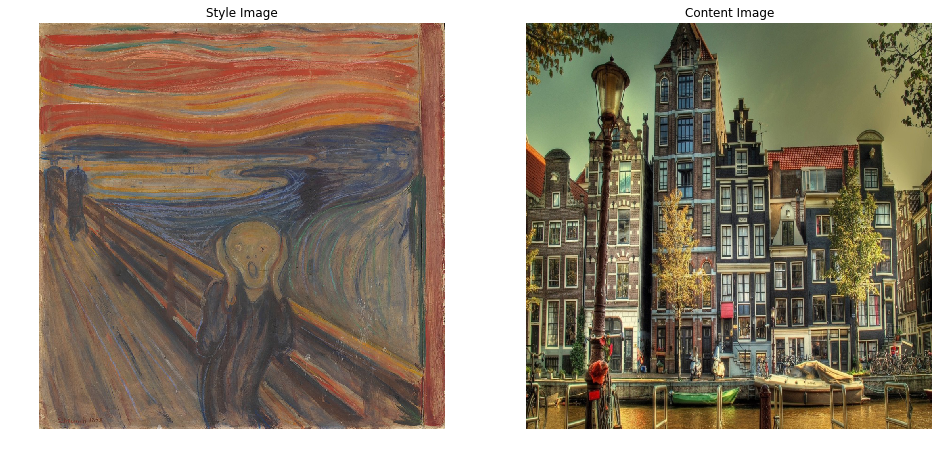

In [0]:
imshow([style_img, content_img], title=['Style Image', 'Content Image'])

#Loss Functions

Here we define our loss functions and our matrix that will be "scrubbing" our image.

Matrix dementions are as follows:
*   A - Batch size
*   B - Number of feature maps
*   C - Dimensions of an f.map (N=C*D)
*   D - The 2nd part of that f.map

In [0]:
def gram_matrix(input):
    # b = batch size (i.e., 1)
    # f = number of feature maps
    # (h,w) = dimensions of a f. map (N=c*d) 
    b, f, h, w = input.size()  

    # resize the input so we can get the gram matrix
    features = input.view(b * f, h * w)
    
    # calculate the ortho-normal basis
    basis = torch.mm(features, features.t())

    # 'normalize' by dividing by the number of elements in each feature map
    gram = basis.div(b * f * h * w)
    
    return gram

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        
        # detach to endsure we don't back prop into our gram matrix
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        
        # mean squared error between the gram matricies of our style image and the input image
        self.loss = F.mse_loss(G, self.target)

        return input

    
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()

        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# Normalization

Normalization of the individual values of the input image will be the first "layer" in our DNN.

In [0]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

#VGG

Because Pytorch has pretrained models already, we're not going to bother training our own. Our model of choice is VGG19 model. See the architecture below. Interestingly, we aren't going to use the whole model, we are going to break it up in a way you might not expect.

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/8bd178f4d32a1108565fb62dde562332a19f6684/3-Figure2-1.png" />



In [0]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:10<00:00, 54459043.87it/s]


# The network

Here is where we're finally are defining our network.

For this, we're using 5 Convolutional(Conv) layers, 5 Rectified Linear Unit (Relu) layer, one Max pooling layer, and a normalizing layer.

You'll notice that we're using 5 convolutions on our style image, but only one on our content image. This is because building an accurate feature map of our style image is much more important, so that we can accurately place style features on the content without disrupting the original image too much. It also helps us add texture from the style image onto the content image.


In [0]:
# desired depth layers to compute style/content losses
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(vgg, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):

    # deep copy before butchering
    vgg = copy.deepcopy(vgg)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # vgg is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in vgg.children():
        if isinstance(layer, nn.Conv2d):
            i += 1 # increment every time we see a conv

            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Add the current vgg layer to our new model
        model.add_module(name, layer)

        if name in content_layers:
            
            # get the activations for the content image at this point in the network
            target = model(content_img).detach()
            
            # set up a loss function inside a model layer
            content_loss = ContentLoss(target)
            
            # this layer calculates loss on the activations then
            # passes the activations through unchanged
            model.add_module("content_loss_{}".format(i), content_loss)

            # We will need to be able to access the the loss for this layer outside the model
            content_losses.append(content_loss)

        if name in style_layers:

            # get the activations for the style image at this point in the network
            target = model(style_img).detach()

            # set up a loss function inside a model layer
            style_loss = StyleLoss(target)

            # this layer calculates loss on the activations then
            # passes the activations through unchanged
            model.add_module("style_loss_{}".format(i), style_loss)

            # We will need to be able to access the the loss for this layer outside the model
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    j = 0
    for j in range(len(model) - 1, -1, -1):
        if isinstance(model[j], ContentLoss) or isinstance(model[j], StyleLoss):
            break

    model = model[:(j + 1)]

    return model, style_losses, content_losses

#Neural Network

Here we are all the way at the end!

Here you get to finally run both the content and style images through the network we've built, in order to analyze and record relevant data about them. We will then modify our cloned image (or white noise if you decided to do that) into a combination of the style from the style image, and the content from the content image.

You can decide the number of epochs you'd like to run to try to get the perfect number of loss (under 5 is great, but be careful not to do too many epochs, otherwise it will flip and you'll get like 30,000 loss) by modifying the num_steps variable in the run_style_transfer() function. You can also adjust the weights (you'll notice that style is at one million currently and content is at 1).

This will run through as many epochs as you set, and report the loss at every multiple of 50.

Congratulations, and have fun!

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(vgg, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""

    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(
        vgg, normalization_mean, normalization_std, style_img, content_img
    )
    
    print("Get the optimizer..")
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
                
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("epoch {}:".format(run[0]))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img



In [0]:
# Set up all done. let's run this thing.
output = run_style_transfer(vgg, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)


Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Get the optimizer..
Optimizing..
epoch 50:
Style Loss : 7.366166 Content Loss: 12.638039

epoch 100:
Style Loss : 2.205576 Content Loss: 8.153148

epoch 150:
Style Loss : 1.019163 Content Loss: 6.792759

epoch 200:
Style Loss : 0.636376 Content Loss: 6.238914

epoch 250:
Style Loss : 0.491444 Content Loss: 5.975693

epoch 300:
Style Loss : 0.434401 Content Loss: 5.835484



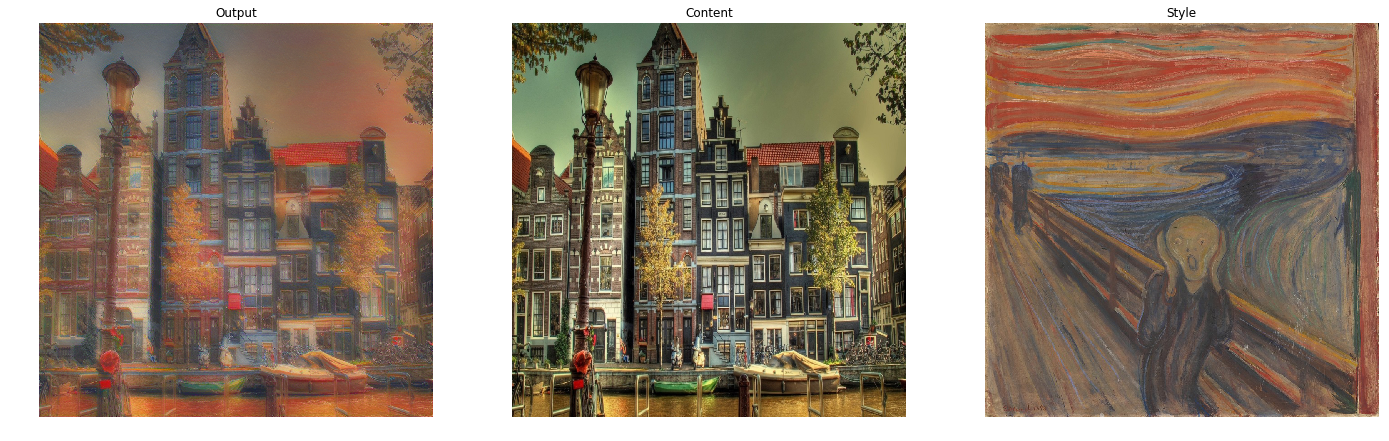

In [0]:
imshow([output, content_img, style_img] , title=['Output','Content', 'Style'])